# Capstone 2 Project - Russian Troll Tweets

### Initial tweet data exploration
First, I'll join together all of the tweet data, reading and joining all of the 13 data files

I will use the Tweets to explore questions about the nature of the disinformation campaign, such as:
* Did the tweets increase in frequency or volume around the time of major events? (EDA)
* Who were the most profilic trolls (volume of tweets)? (EDA)
* Did other trolls retweet and amplify troll tweets? (NLP)
* Can clusters be made of Twitter handles/’users’ grouped with similar features? (NLP)
* Can common topics or themes be identified? (NLP)
* What were the most-used hashtags? (EDA??)
* Did the tweets predominantly support one candidate or political party, or seek to undermine the other? (NLP)



Header | Definition
-------|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?   id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018

In [1]:
import pandas as pd
import numpy as np

In [2]:
# clear all variables from memory
# %reset -f

## Join Data Files
The data is provided in 13 separate CSV files, to deal with GitHub's file upload limit.  These files are joined once into one dataframe for further analysis.

In [3]:
# Join all csv files into one - only run this one time. 
# CSVs were split to get around GitHub's file upload size

# IRAhandle_tweets_1
#import glob, os
 
#os.chdir("../data")
#results = pd.DataFrame([])
 
#for counter, file in enumerate(glob.glob("IRAhandle_tweets*")):
#    namedf = pd.read_csv(file, skiprows=0)
#    results = results.append(namedf)
 
#results.to_csv('../data/all_IRAhandle_tweets.csv')

In [4]:
# Read in the joined dataset - large, ~3 million records. Consider Spark/AWS?
df = pd.read_csv('../data/all_IRAhandle_tweets.csv', parse_dates = ['publish_date', 'harvested_date'], encoding='utf-8',low_memory=False)

/Users/admin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,11,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2946207, 22)


## Explore, clean up data

In [5]:
ivan.dtypes

Unnamed: 0                     int64
external_author_id            object
author                        object
content                       object
region                        object
language                      object
publish_date          datetime64[ns]
harvested_date        datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                     object
account_type                  object
retweet                        int64
account_category              object
new_june_2018                  int64
alt_external_id               object
tweet_id                       int64
article_url                   object
tco1_step1                    object
tco2_step1                    object
tco3_step1                    object
dtype: object

In [6]:
#ivan.head()

In [7]:
ivan.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')

In [8]:
# drop strange first column 'Unnamed: 0'
ivan.drop(['Unnamed: 0'], axis=1,inplace=True)

In [9]:
# drop unneccessary "harvested_date"
ivan.drop("harvested_date",axis=1,inplace=True)

In [10]:
#ivan.describe(include="all")

In [11]:
# Check for/count NAs
ivan.isna().sum()
ivan.isnull().sum().sort_values(ascending = False)

tco3_step1            2931207
tco2_step1            2235090
post_type             1648625
tco1_step1             845971
region                   8818
content                     1
article_url                 0
followers                   0
author                      0
language                    0
publish_date                0
following                   0
updates                     0
tweet_id                    0
account_type                0
retweet                     0
account_category            0
new_june_2018               0
alt_external_id             0
external_author_id          0
dtype: int64

### NAs
* It looks like the 'tcox_stepx' columns are links to photos, etc. OK if some are empty.
* 'region' has 8,748 missing values. May be worth further examination. It's possible that the authors were trying to hide/mask their true region?
* The data dictionary states that the 'post_type' "Indicates if the tweet was a retweet or a quote-tweet".  If NA, is it an original post?

In [12]:
# drop the one NA in the 'content' column 
ivan.dropna(subset = ['content'], inplace = True)

In [13]:
# Take a look at 'post_type' - if it's a post and not a retweet, is it empty?
ivan.loc[ivan['post_type'].isnull()].head(5)
# It appears as though the ['post_type'].isnull() if it is an "original" tweet

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
5,906000000000000000,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,2017-10-01 02:47:00,1050,9644,247,NaN,Right,0,RightTroll,0,905874659358453760,914320835325853696,http://twitter.com/905874659358453760/statuses...,https://twitter.com/FoxNews/status/91423949678...,NaN,NaN
7,906000000000000000,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,2017-10-01 02:52:00,1050,9644,249,NaN,Right,0,RightTroll,0,905874659358453760,914322215537119234,http://twitter.com/905874659358453760/statuses...,NaN,NaN,NaN


In [14]:
ivan.shape

(2946206, 20)

## EDA

In [15]:
#ivan.describe()
ivan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946206 entries, 0 to 2946206
Data columns (total 20 columns):
external_author_id    object
author                object
content               object
region                object
language              object
publish_date          datetime64[ns]
following             int64
followers             int64
updates               int64
post_type             object
account_type          object
retweet               int64
account_category      object
new_june_2018         int64
alt_external_id       object
tweet_id              int64
article_url           object
tco1_step1            object
tco2_step1            object
tco3_step1            object
dtypes: datetime64[ns](1), int64(6), object(13)
memory usage: 472.0+ MB


In [16]:
# how many unique authors?
# df.author.value_counts().shape[0]
len(ivan.author.unique())

2843

### Authors
The approximately 3 million (2.94 million) tweets were created by only 2,843 authors.

In [17]:
# get the number of tweets by the top 25 authors
ivan.author.value_counts().head(25)
#ivan.external_author_id.value_counts().head(25)

EXQUOTE            59174
SCREAMYMONKEY      44001
AMELIEBALDWIN      35261
WORLDNEWSPOLI      35155
TODAYPITTSBURGH    33602
SPECIALAFFAIR      32556
SEATTLE_POST       30793
FINDDIET           29038
KANSASDAILYNEWS    28806
ROOMOFRUMOR        28351
DAILYSANFRAN       27996
WORLDOFHASHTAGS    23724
COVFEFENATIONUS    23544
JENN_ABRAMS        22849
CHICAGODAILYNEW    22148
RIAFANRU           21461
POLITICS_T0DAY     21444
FUNDDIET           19992
BERLINBOTE         19658
CHESPLAYSCHESS     19216
TODAYNYCITY        18498
ONLINECLEVELAND    17666
HYDDROX            17384
OLD_NEW_POLICY     15418
TODAYINSYRIA       15401
Name: author, dtype: int64

In [18]:
top25tweets = ivan.author.value_counts().head(25).sum()

In [19]:
totaltweets = ivan.shape[0]
pctTop25 = (top25tweets/totaltweets) *100
print("The Top 25 authors accounted for ", round(pctTop25,2), "% of the overall troll tweets.")

The Top 25 authors accounted for  22.51 % of the overall troll tweets.


### Users Summary, by Tweet Count

In [20]:
user_tweet_count = ivan.groupby('external_author_id')['content'].agg('count').reset_index()
user_tweet_count.rename(columns = {'external_author_id':'user_id', 'content':'Tweet_count'}, inplace = True)
#user_tweet_count.head()

In [21]:
# get records up to election day
userinfo = ivan.loc[ivan['publish_date'] <= '2016-11-8']

userinfo.sort_values(by=['publish_date'], inplace=True)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
# drop duplicates, so we get only unique users with their followers, following
# but, as these change, we keep='last' to get the follower count closest to election day
# 1261726 rows before
userinfo.drop_duplicates(['external_author_id'], keep='last', inplace=True)
#userinfo.info()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
# join/merge this dataframe with the users data to get the associated followers_count and name.
user_tweet_count_df = user_tweet_count.merge(userinfo,
                                      left_on = 'user_id',
                                      right_on = 'external_author_id')
#check it
#user_tweet_count_df.head(2)

In [24]:
#create a subset dataframe of user info, followers, following
user_totals = user_tweet_count_df[['external_author_id', 'author', 'Tweet_count','region', 'language', 'followers', 'following', 'account_type', 'account_category']]

In [25]:
#user_totals.describe()

In [26]:
user_totals.sort_values(by=['Tweet_count'], ascending=False, inplace=True)
# Reorder columns so Tweet counts, followers and following are together
users = user_totals[['author', 'Tweet_count', 'followers', 'following', 'region', 'language',
       'account_type', 'account_category', 'external_author_id']]

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
## Export cleaned up dataframe to a CSV for NLP work
users.to_csv('../data/users_totals.csv', header=True)

### Top Authors
The top 25 handles accounted for 634,018 tweets.

In [28]:
ivan['following'].describe()  

count    2.946206e+06
mean     3.448729e+03
std      5.625645e+03
min     -1.000000e+00
25%      3.350000e+02
50%      1.506000e+03
75%      4.746000e+03
max      7.621000e+04
Name: following, dtype: float64

In [29]:
#ivan['followers'].describe()

In [30]:
# Get number of unique authors
len(ivan['author'].unique())

2843

In [31]:
# get counts of account_category
# `account_type` - Specific account theme, as coded by Linvill and Warren
ivan['account_category'].value_counts()

NonEnglish      820803
RightTroll      711668
NewsFeed        598226
LeftTroll       427141
HashtagGamer    241785
Commercial      121904
Unknown          13539
Fearmonger       11140
Name: account_category, dtype: int64

## EDA Visualization

In [32]:
# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set(rc={'figure.figsize':(10,6)})

In [33]:
# Plot distribution by 'account_type'
lang = ivan['language'].value_counts()
# get Top 10 languages
# Get counts of top 25 authors
lang = lang.head(10)

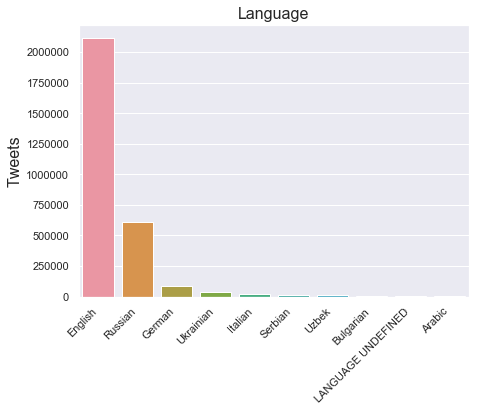

In [34]:
# Create a barplot of Russian Troll Language Type

sns.set(style="whitegrid")
# set figure size
sns.set(rc={'figure.figsize':(7,5)})
# set color palette 
flatui = ["#3498db", "#e74c3c", "#95a5a6"]
sns.set_palette(flatui)

ax = sns.barplot(x=lang.index, y=lang)

# rotate and right align language names
plt.xticks(rotation=45, ha='right')
# set plot and plot parameters
ax = sns.barplot(x=lang.index, y=lang) 
ax.axes.set_title('Language',fontsize=16)
ax.set_ylabel('Tweets',fontsize=16)

plt.show()

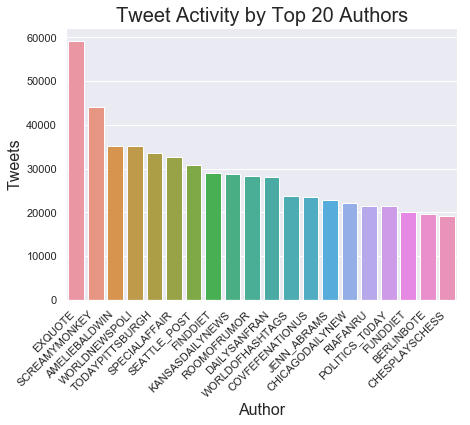

In [35]:
# Plot distribution by 'author' value_counts()
auth = ivan['author'].value_counts()
# Get counts of top 25 authors
auth_25 = auth.head(20)

sns.set(style="whitegrid")
# set figure size
sns.set(rc={'figure.figsize':(7,5)})
# set color palette 
flatui = ["#3498db", "#e74c3c", "#95a5a6"]
sns.set_palette(flatui)

ax = sns.barplot(x=auth_25.index, y=auth_25)

# rotate and right align group names
plt.xticks(rotation=45, ha='right')
# set plot and plot parameters
ax = sns.barplot(x=auth_25.index, y=auth_25) 
ax.axes.set_title("Tweet Activity by Top 20 Authors",fontsize=20)
ax.set_xlabel('Author',fontsize=16)
ax.set_ylabel('Tweets',fontsize=16)

plt.show()

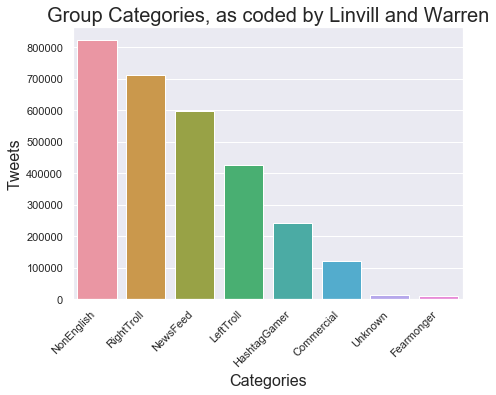

In [36]:
# Create a barplot of Russian Troll Group Category, as coded by Linvill and Warren (Clemson)

# Plot distribution by 'account_category' value_counts()
acct_cat = ivan['account_category'].value_counts()

sns.set(style="whitegrid")
# set figure size
sns.set(rc={'figure.figsize':(7,5)})
# set color palette 
flatui = ["#3498db", "#e74c3c", "#95a5a6"]
sns.set_palette(flatui)

ax = sns.barplot(x=acct_cat.index, y=acct_cat)

# rotate and right align group names
plt.xticks(rotation=45, ha='right')
# set plot and plot parameters
ax = sns.barplot(x=acct_cat.index, y=acct_cat) 
ax.axes.set_title("Group Categories, as coded by Linvill and Warren",fontsize=20)
ax.set_xlabel('Categories',fontsize=16)
ax.set_ylabel('Tweets',fontsize=16)

plt.show()

## Troll tweet activity timeline

In [37]:
# Check 'publish_date' format
ivan['publish_date'].head()

0   2017-10-01 19:58:00
1   2017-10-01 22:43:00
2   2017-10-01 22:50:00
3   2017-10-01 23:52:00
4   2017-10-01 02:13:00
Name: publish_date, dtype: datetime64[ns]

In [38]:
# Create a new column 'publish_date_short' to only capture date, not time
# don't want to convert the date/time, in case we want it later
ivan['publish_date_short'] = ivan['publish_date'].dt.date
# check it
# ivan['publish_date_short']

In [39]:
# Prepare 'publish_date' to be read and plotted on a time line

# first, let's look at the range of time that the tweets are captured from
first_tweet_date = ivan['publish_date_short'].min()
last_tweet_date = ivan['publish_date_short'].max()

print("The time range that the tweets were captured from: ",first_tweet_date,"-",last_tweet_date)

The time range that the tweets were captured from:  2012-02-02 - 2018-05-30


In [40]:
# Create counts for each day, for plotting
# Count the number of times a date appears in the dataset and convert to dataframe
timeline = pd.DataFrame(ivan['publish_date_short'].value_counts())

# value_counts() uses 'publish_date_short' as the index, and the columns 
# are the volume/count on that day
timeline.columns = ['daily_tweet_count']

# sort by 'publish_date_short'
timeline.sort_index(ascending = True, inplace = True)

#check it
#timeline.head()

Text(0, 0.5, 'Tweet Volume')

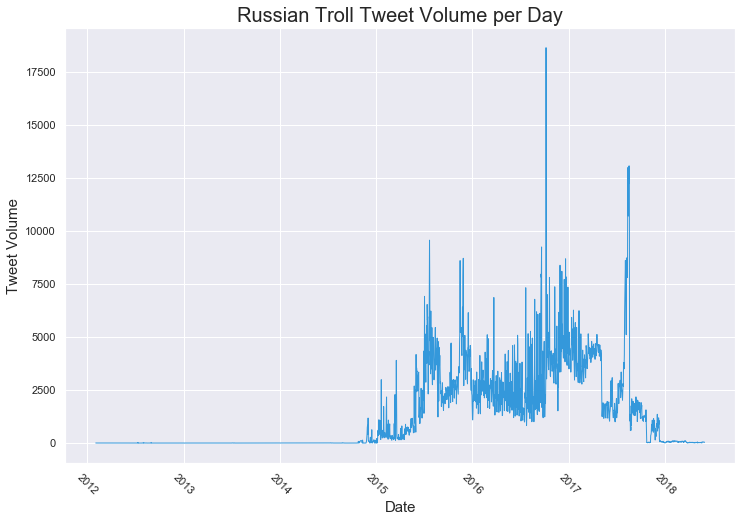

In [41]:
# make a line plot of the tweet count data and give some pretty labels! ;)
# the 'rot' argument control x-axis ticks rotation # color = 'k'
timeline['daily_tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = -45,
                               linewidth = 1)
plt.title('Russian Troll Tweet Volume per Day', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Tweet Volume', fontsize = 15)

Looking at the timeline of Russian Troll activity, we see that the vast majority of activity takes place from the beginning of 2015 through 2017, tailing off before the start of 2018.  Let's trim the dates we're looking at to eliminate the noise and focus on the heavy activity.

In [42]:
# Let's try this again... trim dates to focus on the 2015-2018 window
import datetime
#start_date = '2014-07-01'
start_date = datetime.datetime.strptime('2015-Jun','%Y-%b').date()
end_date = datetime.datetime.strptime('2018-Jan','%Y-%b').date()
mask = (timeline.index >= start_date)  & (timeline.index <= end_date)
trimmed_timeline = timeline.iloc[mask]
trimmed_timeline.head()
#start_date

,daily_tweet_count
2015-06-01,4175
2015-06-02,2420
2015-06-03,3545
2015-06-04,3367
2015-06-05,3389


### Significant Dates
Let's annotate significant dates on the timeline, to see how they align with spikes in troll activity.
* According to Wikipedia, Donald Trump announced his candidacy on June 16, 2015. 
* The 2016 Presidential Election was held on November 8, 2016
* On January 6, 2017, the United States government's intelligence agencies concluded that the Russian government interfered in the 2016 United States elections.
https://en.wikipedia.org/wiki/Donald_Trump_2016_presidential_campaign

Text(0, 0.5, 'Tweet Volume')

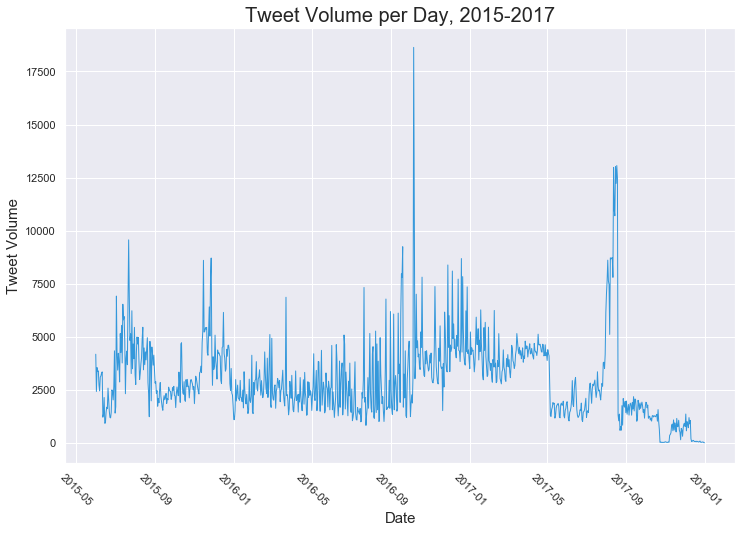

In [43]:
# make a line plot of the tweet count from 2014-2018
trimmed_timeline['daily_tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = -45,
                               linewidth = 1)
plt.title('Tweet Volume per Day, 2015-2017', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Tweet Volume', fontsize = 15)

## Annotated Timeline
The annotated timeline below shows a clear relationship between important and often contentious events in the 2016 Presidential Campaign and the Russian troll activity.  A good reference for significant dates in the campaign cycle can be <a href="https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election">found on Wikipedia</a>.

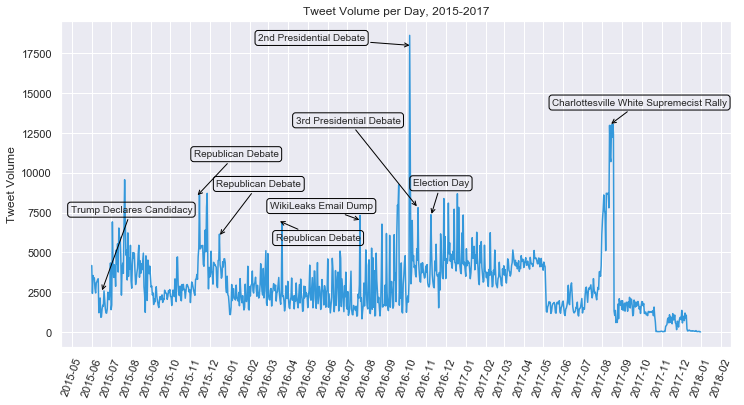

In [44]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
trimmed_timeline['daily_tweet_count'].plot(ax=ax)

# Add labels to the plot
style = dict(size=10, color='gray')

#ax.text('2016-11-8', 5000, "Election Day", ha='left', **style)
ax.annotate("Election Day", xy=('2016-11-8', 7300),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(10, 30), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
#ax.annotate("Russion Interference Announced", xy=('2017-1-6', 4000),  xycoords='data',
#            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
#            xytext=(40, 90), textcoords='offset points', ha='center',
#            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("2nd Presidential Debate", xy=('2016-10-9', 18000),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(-100, 5), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
#ax.annotate("1st Presidential Debate", xy=('2016-9-26', 4000),  xycoords='data',
#            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
#            xytext=(-60, 40), textcoords='offset points', ha='center',
#            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("3rd Presidential Debate", xy=('2016-10-19', 7800),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(-70, 85), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("Trump Declares Candidacy", xy=('2015-6-16', 2500),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(30, 80), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("Charlottesville White Supremecist Rally", xy=('2017-8-12', 13000),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(30, 20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("Republican Debate", xy=('2015-11-10', 8500),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(40, 40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("Republican Debate", xy=('2015-12-15', 6000),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(40, 50), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("Republican Debate", xy=('2016-3-16', 7000),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(40, -20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
ax.annotate("WikiLeaks Email Dump", xy=('2016-7-23', 7000),  xycoords='data',
            bbox=dict(boxstyle="round", facecolor='black', fc="none", ec="black"),
            xytext=(-40, 12), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))


# Label the axes
ax.set(title='Tweet Volume per Day, 2015-2017',
       ylabel='Tweet Volume')

#rotate data labels on x-axis
plt.xticks(rotation=70)
# Format the x axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())

## Following / Followers

In [45]:
#ivan[['author', 'region','followers']].sort_values('followers', ascending = False)[:10]
#user_tweet_count_df[['name', 'Tweet_count']].sort_values('Tweet_count', ascending = False)[:10].\

### Quick Look at Frequency of Words in Tweets

In [46]:
# import nltk libraries
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [47]:
# function to plot most frequent terms
def freq_words(x, terms = 25):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    return d

In [48]:
counts = freq_words(ivan['content'], 25)

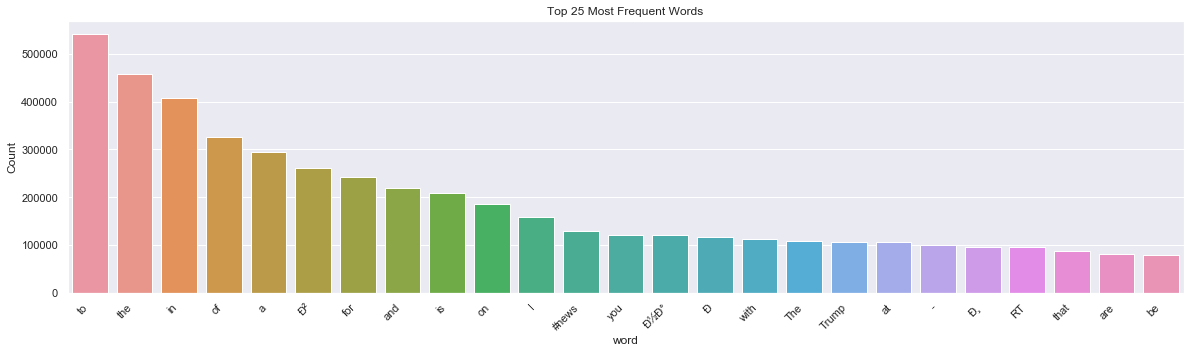

In [49]:
# Plot most frequent words
plt.figure(figsize=(20,5))
# rotate and right align group names
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(data=counts, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Top 25 Most Frequent Words')    
plt.show()

Examining the most frequent words in the tweet content, it becomes obvious that removing "stopwords" is required.  Stop words are words that don't have meaning on their own - like "to", "the", "in", "a", etc.  Removal of stopwords will take place in the NLP text pre-processing stage.

### Export
Export cleaned data file for use in NLP

In [50]:
## Export cleaned up dataframe to a CSV for NLP work
#ivan.to_csv('../data/cleaned_tweets.csv', header=True)